<a href="https://colab.research.google.com/github/EricSiq/DeepLearning/blob/main/Experiment_No5_MNIST_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


MNIST Digit Recognition with Convolutional Neural Network (CNN)

Objectives implemented in this script:
1. Study the MNIST dataset (exploratory checks & sample visualizations)
2. Study / document core CNN concepts used (in comments and brief notes)
3. Implement a clean, well-commented CNN to classify MNIST digits, train it,
   evaluate it, visualize results and save the trained model.


In [ ]:
# Step 0: importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import random

TensorFlow version: 2.19.0
GPU available: []
Train images: (60000, 28, 28), Train labels: (60000,)
Test images:  (10000, 28, 28), Test labels:  (10000,)


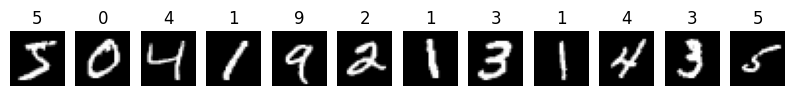

After reshape: (60000, 28, 28, 1) (10000, 28, 28, 1)


In [2]:
# Reproducibility seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# Optional: print TensorFlow version and whether using GPU
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


# Step 1: Load the MNIST dataset

# Keras provides MNIST built-in. It returns train and test splits.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Train images: {x_train.shape}, Train labels: {y_train.shape}")
print(f"Test images:  {x_test.shape}, Test labels:  {y_test.shape}")

# Quick sanity checks and visualization function
def show_samples(images, labels, n=12, cmap='gray'):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.show()

show_samples(x_train, y_train, n=12)


# Step 2: Understand the data shape & basic preprocessing

# MNIST images are 28x28 grayscale with integer pixel values in range 0-255.
# For CNNs we typically: (1) normalize to [0, 1], (2) reshape to include channel dim

IMG_ROWS, IMG_COLS = 28, 28
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 1)
NUM_CLASSES = 10

# Normalize and reshape
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension for Keras (channels_last format)
x_train = np.expand_dims(x_train, -1)  # shape -> (N, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

print('After reshape:', x_train.shape, x_test.shape)

# Convert labels to one-hot vectors for categorical crossentropy
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

TensorFlow version: 2.19.0
GPU available: []
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train images: (60000, 28, 28), Train labels: (60000,)
Test images:  (10000, 28, 28), Test labels:  (10000,)


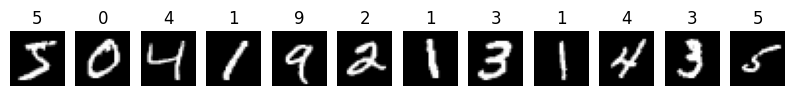

After reshape: (60000, 28, 28, 1) (10000, 28, 28, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,818 (1.78 MB)

 Trainable params: 467,818 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7908 - loss: 0.6372
Epoch 1: val_loss improved from inf to 0.04730, saving model to mnist_cnn_checkpoints/best_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 199s 457ms/step - accuracy: 0.7910 - loss: 0.6365 - val_accuracy: 0.9848 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9679 - loss: 0.1061
Epoch 2: val_loss improved from 0.04730 to 0.04053, saving model to mnist_cnn_checkpoints/best_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 181s 430ms/step - accuracy: 0.9679 - loss: 0.1061 - val_accuracy: 0.9875 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9789 - loss: 0.0754
Epoch 3: val_loss improved from 0.04053 to 0.03180, saving model to mnist_cnn_checkpoints/best_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 206s 439ms/step - accuracy: 0.9789 - loss: 0.0754 - val_accuracy: 0.9908 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9822 - loss: 0.0574
Epoch 4: val_loss improved from 0.03180 to 0.02846, saving model to mnist_cnn_checkpoints/best_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 200s 434ms/step - accuracy: 0.9822 - loss: 0.0574 - val_accuracy: 0.9915 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9843 - loss: 0.0532
Epoch 5: val_loss improved from 0.02846 to 0.02739, saving model to mnist_cnn_checkpoints/best_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 202s 434ms/step - accuracy: 0.9843 - loss: 0.0532 - val_accuracy: 0.9922 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9869 - loss: 0.0432
Epoch 6: val_loss did not improve from 0.02739
422/422 ━━━━━━━━━━━━━━━━━━━━ 202s 434ms/step - accuracy: 0.9869 - loss: 0.0432 - val_accuracy: 0.9922 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9887 - loss: 0.0375
Epoch 7: val_loss did not improve from 0.02739
422/422 ━━━━━━━━━━━━━━━━━━━━ 184s 436ms/step - accuracy: 0.9887 - loss: 0.0375 - val_accuracy: 0.9932 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9894 - loss: 0.0351
Epoch 8: val_loss did not improve from 0.02739

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 433ms/step - accuracy: 0.9894 - loss: 0.0351 - va

422/422 ━━━━━━━━━━━━━━━━━━━━ 181s 430ms/step - accuracy: 0.9919 - loss: 0.0274 - val_accuracy: 0.9940 - val_loss: 0.0234 - learning_rate: 5.0000e-04
Epoch 10/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9923 - loss: 0.0248
Epoch 10: val_loss did not improve from 0.02336
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 433ms/step - accuracy: 0.9923 - loss: 0.0248 - val_accuracy: 0.9935 - val_loss: 0.0262 - learning_rate: 5.0000e-04
Epoch 11/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9937 - loss: 0.0202
Epoch 11: val_loss did not improve from 0.02336
422/422 ━━━━━━━━━━━━━━━━━━━━ 200s 428ms/step - accuracy: 0.9937 - loss: 0.0202 - val_accuracy: 0.9935 - val_loss: 0.0281 - learning_rate: 5.0000e-04
Epoch 12/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9935 - loss: 0.0211
Epoch 12: val_loss improved from 0.02336 to 0.02321, saving model to mnist_cnn_checkpoints/best_model.h5


422/422 ━━━━━━━━━━━━━━━━━━━━ 181s 428ms/step - accuracy: 0.9935 - loss: 0.0211 - val_accuracy: 0.9953 - val_loss: 0.0232 - learning_rate: 5.0000e-04
Epoch 13/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9943 - loss: 0.0174
Epoch 13: val_loss did not improve from 0.02321
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 432ms/step - accuracy: 0.9943 - loss: 0.0174 - val_accuracy: 0.9947 - val_loss: 0.0247 - learning_rate: 5.0000e-04
Epoch 14/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9941 - loss: 0.0188
Epoch 14: val_loss did not improve from 0.02321
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 434ms/step - accuracy: 0.9941 - loss: 0.0188 - val_accuracy: 0.9937 - val_loss: 0.0251 - learning_rate: 5.0000e-04
Epoch 15/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9942 - loss: 0.0174
Epoch 15: val_loss did not improve from 0.02321

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
422/422 ━━━━━━━━━━━━━━━━━━━━ 182s 431ms/step - accuracy: 0.9942 

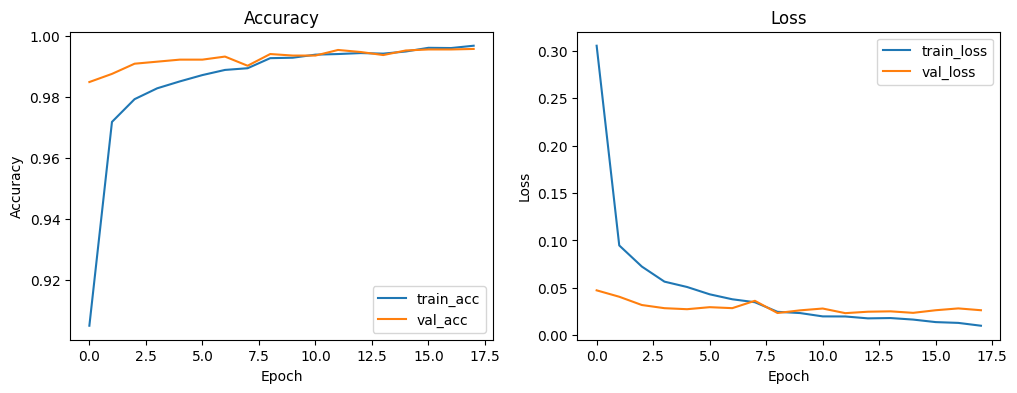

313/313 - 9s - 29ms/step - accuracy: 0.9948 - loss: 0.0163
Test loss: 0.0163, Test accuracy: 0.9948
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


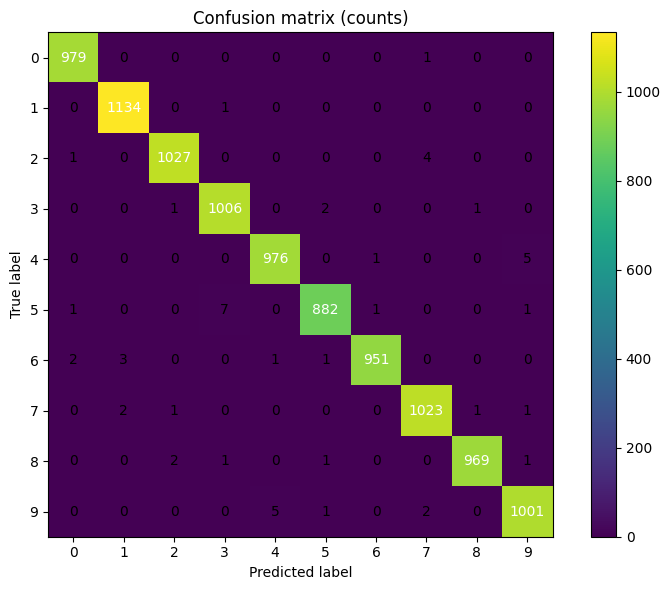


Classification Report:

              precision    recall  f1-score   support

           0     0.9959    0.9990    0.9975       980
           1     0.9956    0.9991    0.9974      1135
           2     0.9961    0.9952    0.9956      1032
           3     0.9911    0.9960    0.9936      1010
           4     0.9939    0.9939    0.9939       982
           5     0.9944    0.9888    0.9916       892
           6     0.9979    0.9927    0.9953       958
           7     0.9932    0.9951    0.9942      1028
           8     0.9979    0.9949    0.9964       974
           9     0.9921    0.9921    0.9921      1009

    accuracy                         0.9948     10000
   macro avg     0.9948    0.9947    0.9947     10000
weighted avg     0.9948    0.9948    0.9948     10000



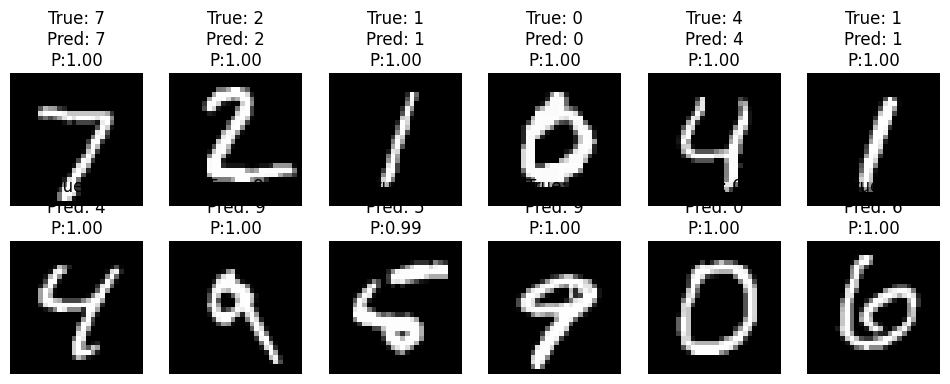

Saved final model to mnist_cnn_checkpoints/mnist_cnn_final.h5

- Data augmentation (rotation, shift, shear) can help generalization for noisy variants.
- Try BatchNormalization after Conv layers for faster, more stable training.
- Smaller learning rate with scheduler sometimes yields a bump in final accuracy.
- Try GlobalAveragePooling2D instead of Flatten for lighter models.
- For deployment on mobile/embedded devices, convert the model to TFLite and apply quantization.
- If you prefer PyTorch, re-implement the same architecture using nn.Conv2d, nn.MaxPool2d, Dropout, etc.
- For near-state-of-the-art on MNIST you can reach >99.5% with deeper nets, ensembling or simple tricks.



In [1]:






# Step 3: Brief CNN concept notes (in-code)

# - Conv2D layer: learns local patterns using filters (kernels). Filters detect edges, curves, etc.
# - Activation (ReLU): introduces non-linearity for the network to model complex functions.
# - MaxPooling2D: reduces spatial size (downsampling) and provides translation invariance.
# - Dropout: regularization to reduce overfitting by randomly dropping units during training.
# - BatchNormalization (optional): stabilizes and speeds up training.
# - Flatten or GlobalAveragePooling2D: converts spatial feature maps to vector for Dense layers.
# - Dense + softmax: final classification layer to output probabilities over classes.


# Step 4: Build a clean CNN model

def build_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """Return a compiled Keras CNN model for MNIST.

    Architecture (simple-robust):
    - Conv(32,3x3) -> ReLU
    - Conv(32,3x3) -> ReLU -> MaxPool -> Dropout
    - Conv(64,3x3) -> ReLU
    - Conv(64,3x3) -> ReLU -> MaxPool -> Dropout
    - Flatten -> Dense(128) -> ReLU -> Dropout -> Dense(num_classes) -> softmax
    """
    model = Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Classification head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model with a common setup for multiclass classification
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build and inspect the model
model = build_cnn()
model.summary()


# Step 5: Prepare callbacks for training

# - EarlyStopping to avoid overfitting
# - ModelCheckpoint to save the best model
# - ReduceLROnPlateau to lower learning rate on plateau

SAVE_DIR = 'mnist_cnn_checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)
checkpoint_path = os.path.join(SAVE_DIR, 'best_model.h5')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


# Step 6: Train the model

EPOCHS = 20
BATCH_SIZE = 128

history = model.fit(
    x_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,  # keep 10% of training data for validation
    callbacks=callbacks,
    shuffle=True
)


# Step 7: Plot training curves (loss & accuracy)

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='train_acc')
    axes[0].plot(history.history['val_accuracy'], label='val_acc')
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Loss
    axes[1].plot(history.history['loss'], label='train_loss')
    axes[1].plot(history.history['val_loss'], label='val_loss')
    axes[1].set_title('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.show()

plot_history(history)


# Step 8: Evaluate on test set

loss, acc = model.evaluate(x_test, y_test_cat, verbose=2)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")


# Step 9: Confusion matrix & classification report

# Predictions
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=None):
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=list(range(NUM_CLASSES)), normalize=False,
                      title='Confusion matrix (counts)')

# Classification report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, digits=4))



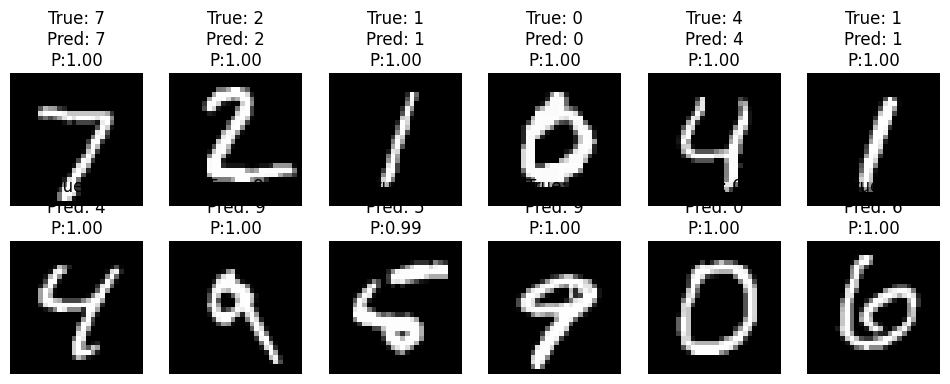

Saved final model to mnist_cnn_checkpoints/mnist_cnn_final.h5

- Data augmentation (rotation, shift, shear) can help generalization for noisy variants.
- Try BatchNormalization after Conv layers for faster, more stable training.
- Smaller learning rate with scheduler sometimes yields a bump in final accuracy.
- Try GlobalAveragePooling2D instead of Flatten for lighter models.
- For deployment on mobile/embedded devices, convert the model to TFLite and apply quantization.
- If you prefer PyTorch, re-implement the same architecture using nn.Conv2d, nn.MaxPool2d, Dropout, etc.
- For near-state-of-the-art on MNIST you can reach >99.5% with deeper nets, ensembling or simple tricks.



In [3]:

# Step 10: Visualize some predictions

def visualize_predictions(images, true_labels, pred_labels, probs=None, n=12):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        ax = plt.subplot(2, n//2, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        title = f'True: {true_labels[i]}\nPred: {pred_labels[i]}'
        if probs is not None:
            title += f"\nP:{probs[i][pred_labels[i]]:.2f}"
        plt.title(title)
        plt.axis('off')
    plt.show()

visualize_predictions(x_test, y_test, y_pred, y_pred_probs, n=12)


# Step 11: Save the final model and weights

FINAL_MODEL_PATH = os.path.join(SAVE_DIR, 'mnist_cnn_final.h5')
model.save(FINAL_MODEL_PATH)
print('Saved final model to', FINAL_MODEL_PATH)


# Step 12: Short notes on improvements & experiments

notes = '''
- Data augmentation (rotation, shift, shear) can help generalization for noisy variants.
- Try BatchNormalization after Conv layers for faster, more stable training.
- Smaller learning rate with scheduler sometimes yields a bump in final accuracy.
- Try GlobalAveragePooling2D instead of Flatten for lighter models.
- For deployment on mobile/embedded devices, convert the model to TFLite and apply quantization.
- If you prefer PyTorch, re-implement the same architecture using nn.Conv2d, nn.MaxPool2d, Dropout, etc.
- For near-state-of-the-art on MNIST you can reach >99.5% with deeper nets, ensembling or simple tricks.
'''
print(notes)
